In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, itertools
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

# Загрузка датасета

In [2]:
sample_image = torchvision.io.read_image("/kaggle/input/edges2shoes-dataset/train/10000_AB.jpg")
sample_image.shape

torch.Size([3, 256, 512])

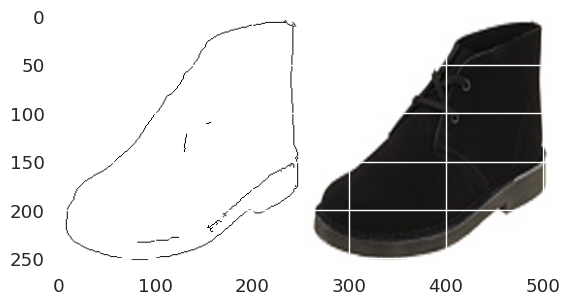

In [3]:
imgplot = plt.imshow(sample_image.permute(1, 2, 0))
plt.show()

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
batch_size = 2
# number of cpu threads to use during batch generation
n_workers = 8
# size of image height
img_height = 256
# size of image width
img_width = 256

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = tt.Compose(transforms_)
        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [7]:
transforms_ = [
    tt.Resize((img_height, img_width), Image.BICUBIC),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
train_dataloader = DataLoader(
    ImageDataset("/kaggle/input/edges2shoes-dataset", transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

torch.Size([2, 3, 256, 256])


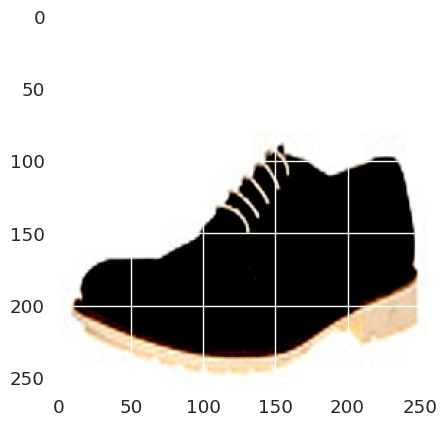

In [8]:
test_batch = None

for batch in train_dataloader:
    
    test_batch = batch
    
    print(test_batch["A"].shape)
    
    imgplot = plt.imshow(test_batch["B"][0].permute(1, 2, 0))
    plt.show()
    
    break
    

# Generator

In [9]:
class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, apply_batchnorm=True):
        super(Downsampler, self).__init__()
    
        if apply_batchnorm:
            self.module = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(inplace = True),
            )
        else:
            self.module = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(inplace = True),
            )

    def forward(self, x):
        return self.module(x)

In [10]:
downsampler = Downsampler(in_channels=3, out_channels=64)
x = torch.randn(1, 3, 256, 256)
x = downsampler(x)

print(x.shape)

torch.Size([1, 64, 128, 128])


In [11]:
class Upsampler(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(Upsampler, self).__init__()

        if apply_dropout:
            self.module = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5),
                nn.ReLU(inplace = True),
            )
        else: 
            self.module = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace = True),
            )

    def forward(self, x):
        return self.module(x)

In [12]:
upsampler = Upsampler(in_channels=64, out_channels=3)
x = torch.randn(1, 64, 256, 256)
x = upsampler(x)

print(x.shape)

torch.Size([1, 3, 512, 512])


In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # (batch_size, 3, 256, 256)
        
        self.downsample_1 =  Downsampler(3, 64, apply_batchnorm = False) # (batch_size, 64, 128, 128)
        self.downsample_2 =  Downsampler(64, 128) # (batch_size, 128, 64, 64)
        self.downsample_3 =  Downsampler(128, 256) # (batch_size, 256, 32, 32)
        self.downsample_4 =  Downsampler(256, 512) # (batch_size, 512, 16, 16)
        self.downsample_5 =  Downsampler(512, 512) # (batch_size, 512, 8, 8)
        self.downsample_6 =  Downsampler(512, 512) # (batch_size, 512, 4, 4)
        self.downsample_7 =  Downsampler(512, 512) # (batch_size, 512, 2, 2)
        self.downsample_8 = Downsampler(512, 512) # (batch_size, 512, 1, 1)
        
        self.upsample_1 = Upsampler(512, 512, apply_dropout=True) # (batch_size, 512, 2, 2)
        self.upsample_2 = Upsampler(1024, 512, apply_dropout=True) # (batch_size, 512, 4, 4)
        self.upsample_3 = Upsampler(1024, 512, apply_dropout=True) # (batch_size, 512, 8, 8)
        self.upsample_4 = Upsampler(1024, 512) # (batch_size, 512, 16, 16)
        self.upsample_5 = Upsampler(1024, 256) # (batch_size, 256, 32, 32)
        self.upsample_6 = Upsampler(512, 128) # (batch_size, 128, 64, 64)
        self.upsample_7 = Upsampler(256, 64) # (batch_size, 64, 128, 128)
        
        
        self.last = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        skips = []
        
        x = self.downsample_1(x)
        skips.append(x)
        x = self.downsample_2(x)
        skips.append(x)
        x = self.downsample_3(x)
        skips.append(x)
        x = self.downsample_4(x)
        skips.append(x)
        x = self.downsample_5(x)
        skips.append(x)
        x = self.downsample_6(x)
        skips.append(x)
        x = self.downsample_7(x)
        skips.append(x)
        x = self.downsample_8(x)
        skips.append(x)

        skips = list(reversed(skips[:-1]))
        
        
        
        x = self.upsample_1(x)
        x = torch.cat((x, skips[0]), dim=1)
        x = self.upsample_2(x)
        x = torch.cat((x, skips[1]), dim=1)
        x = self.upsample_3(x)
        x = torch.cat((x, skips[2]), dim=1)
        x = self.upsample_4(x)
        x = torch.cat((x, skips[3]), dim=1)
        x = self.upsample_5(x)
        x = torch.cat((x, skips[4]), dim=1)
        x = self.upsample_6(x)
        x = torch.cat((x, skips[5]), dim=1)
        x = self.upsample_7(x)
        x = torch.cat((x, skips[6]), dim=1)
        
        x = self.last(x)
        
        return x

# Проверка работы генератора

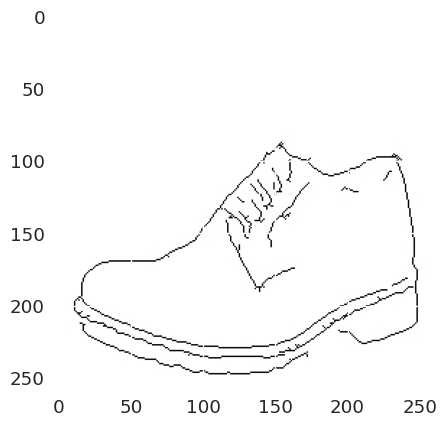

In [14]:
imgplot = plt.imshow(test_batch["A"][0].permute(1, 2, 0).detach().numpy())
plt.show()

In [15]:
generator = Generator().to(device)

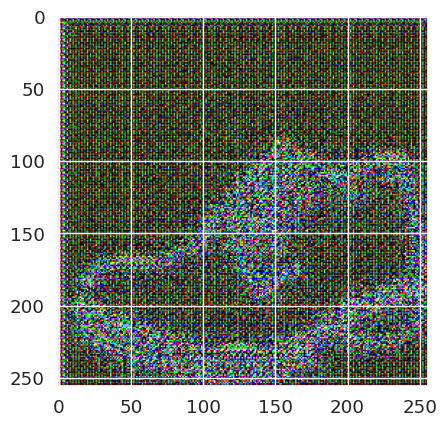

In [16]:
img = generator(test_batch["A"].to(device))[0]

imgplot = plt.imshow(img.permute(1, 2, 0).cpu().detach().numpy())
plt.show()

### Generator loss

In [17]:
LAMBDA = 10

obj_loss = nn.BCEWithLogitsLoss()

def generator_loss(disc_generated_output, gen_output, target):
    
#     print(disc_generated_output)
#     print(gen_output)
#     print(target)
    
    gan_loss = obj_loss(torch.ones_like(disc_generated_output), disc_generated_output)
        
    

      # Mean absolute error
    l1_loss = torch.mean(torch.abs(target - gen_output))
    
#     print("gan_loss", gan_loss)
#     print("l1_loss", l1_loss)

    total_gen_loss = torch.abs(gan_loss) + (LAMBDA * torch.abs(l1_loss))

    return total_gen_loss, gan_loss, l1_loss

# Discriminator

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Определить слои модели
        self.down1 = Downsampler(6, 64, apply_batchnorm = False) # (batch_size, 64, 128, 128)
        self.down2 = Downsampler(64, 128) # (batch_size, 128, 64, 64)
        self.down3 = Downsampler(128, 256) # (batch_size, 256, 32, 32)
        
        self.zero_pad1 = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(256,512, 4, stride=1, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.zero_pad2 = nn.ZeroPad2d(1)
        self.last = nn.Conv2d(512, 1, 4, stride=1, padding=0)

    def forward(self, inp, tar):
        # Объединить входной и целевой тензоры
        x = torch.cat([inp, tar], dim=1)

        # Применить слои свертки и понижения размерности
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        # Применить слои свертки и батч-нормализации
        zero_pad1 = self.zero_pad1(down3)
        conv = self.conv(zero_pad1)
        batchnorm1 = self.batchnorm1(conv)

        # Применить функцию активации
        leaky_relu = self.leaky_relu(batchnorm1)

        # Применить слои свертки и паддинга
        zero_pad2 = self.zero_pad2(leaky_relu)
        last = self.last(zero_pad2)

        return last

# Проверка работы дискриминатора

In [19]:
discriminator = Discriminator()

# Создать случайный входной и целевой тензоры
inp = torch.randn(batch_size, 3, 256, 256)
gen_output = torch.randn(batch_size, 3, 256, 256)

# Вычислить выход модели
disc_out = discriminator(inp, gen_output)[0].permute(1, 2, 0)

disc_out.shape

torch.Size([30, 30, 1])

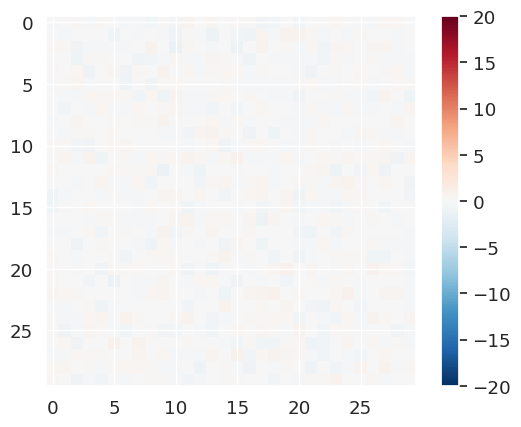

In [20]:
# Отобразить выход модели
plt.imshow(disc_out.detach().numpy(), vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = obj_loss(torch.ones_like(disc_real_output), disc_real_output)

    generated_loss = obj_loss(torch.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = torch.abs(real_loss) + torch.abs(generated_loss)

    return total_disc_loss

## Функция generate_images, позволяющая отобразить батч

In [22]:
def generate_images(model, test_input, tar):
    prediction = generator(test_input)
    
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0].cpu().permute(1, 2, 0), tar[0].cpu().permute(1, 2, 0), prediction[0].permute(1, 2, 0).cpu().detach().numpy()]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

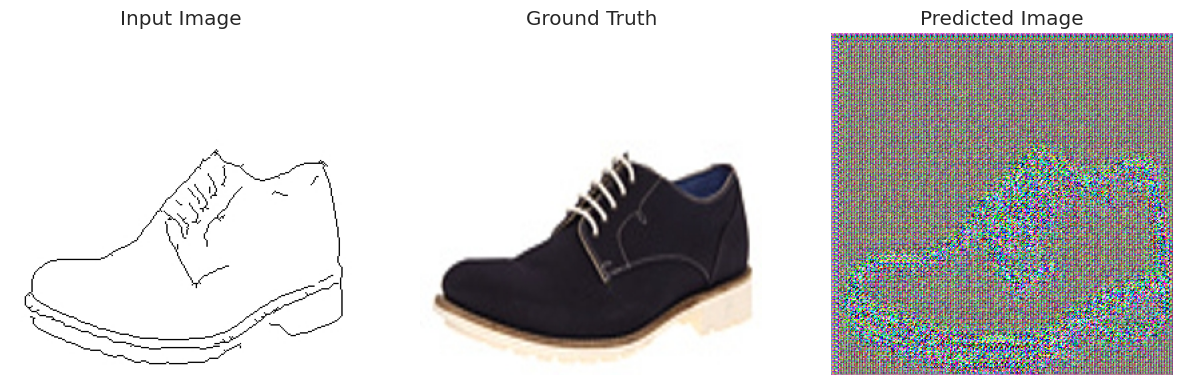

In [23]:
generate_images(generator, test_batch["A"].to(device), test_batch["B"].to(device))

# Тренировка модели

In [24]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [25]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = 2e-4, betas=(0.9, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 2e-4, betas=(0.9, 0.999))

In [26]:
epochs_num = 10

In [27]:
def save_model(version):
    torch.save(generator, f"/kaggle/working/generator_{version}.pt")
    torch.save(discriminator, f"/kaggle/working/discriminator_{version}.pt")

In [28]:
def train():
    version = 0
    for epoch in tqdm(range(0, epochs_num), desc ="Epoch"):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        
        tqdm_bar = tqdm(train_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(train_dataloader)))
        
        generator.train()
        discriminator.train()

        
        for batch in enumerate(tqdm_bar):
            
            generator_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            
            if len(batch[1]["A"]) == 1:
                continue
            
            batch = batch[1]
            

            input_image = batch["A"].to(device)
            output_image = batch["B"].to(device)
            
            gen_output = generator(input_image)
            
            disc_real_output = discriminator(input_image, output_image)
            disc_generated_output = discriminator(input_image, gen_output)
            
            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, output_image)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
            

            
            total_loss = torch.abs(gen_total_loss) + torch.abs(disc_loss)
            
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
            
            
            total_loss.backward()

            
            generator_optimizer.step()
            discriminator_optimizer.step()
            
            epoch_disc_loss += disc_loss
            epoch_gen_loss +=  gen_total_loss
        
        print(f"Epoch disc loss: {epoch_disc_loss}")
        print(f"Epoch gen loss: {epoch_gen_loss}")
        
        generate_images(generator, test_batch["A"].to(device), test_batch["B"].to(device))
        
        save_model(version)
        
        version+=1
            

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 18007.541015625
Epoch gen loss: 41585.04296875


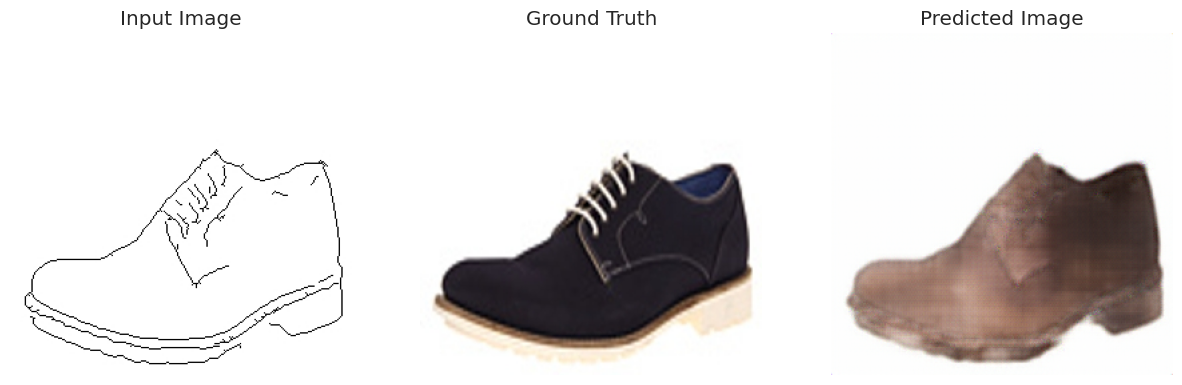

Testing Epoch 1 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17493.380859375
Epoch gen loss: 33939.21875


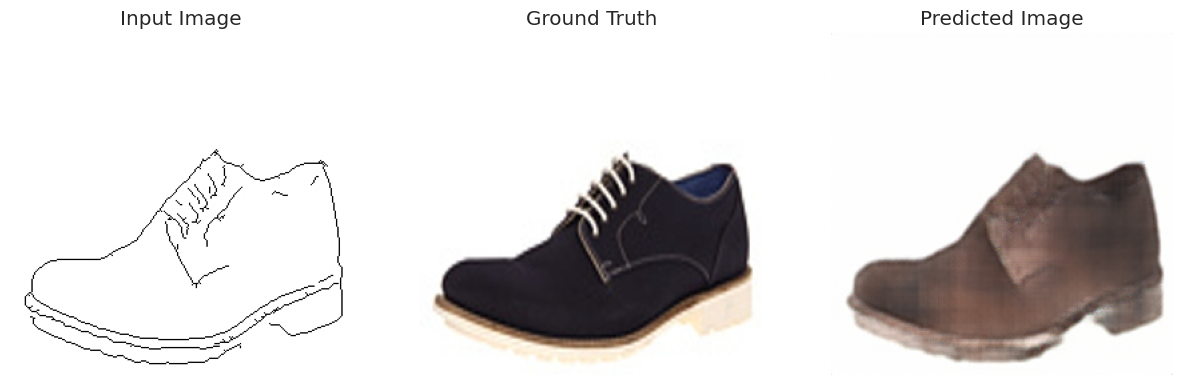

Testing Epoch 2 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17413.921875
Epoch gen loss: 31300.2890625


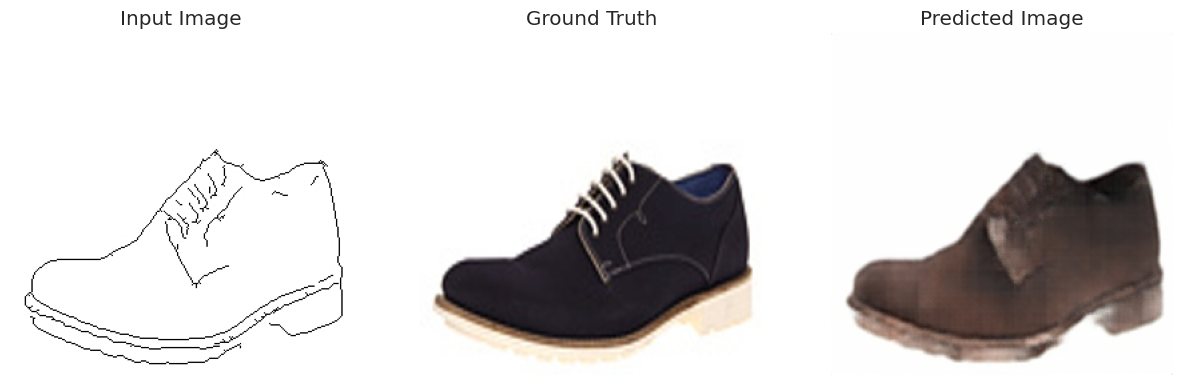

Testing Epoch 3 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17381.771484375
Epoch gen loss: 29620.02734375


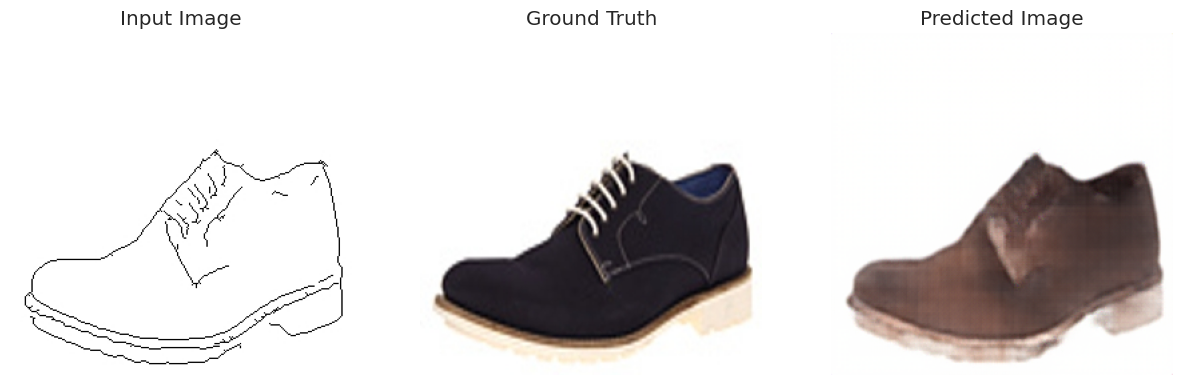

Testing Epoch 4 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17362.6640625
Epoch gen loss: 28337.1875


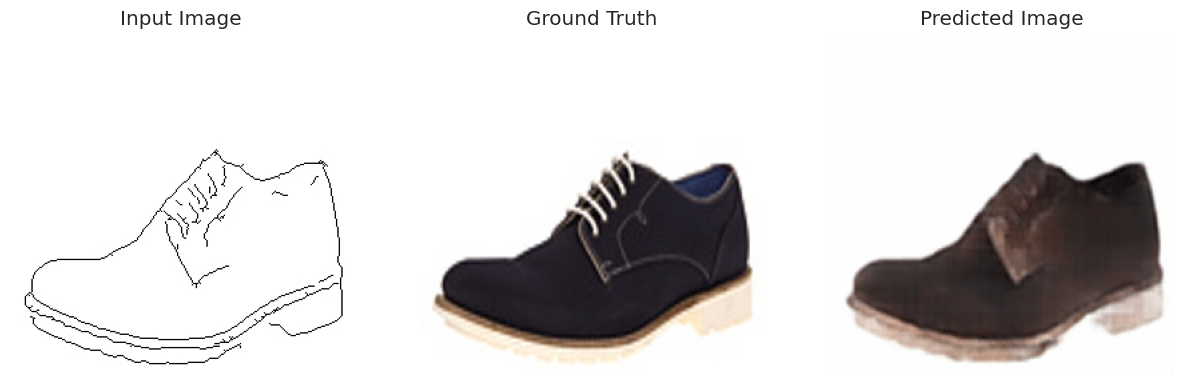

Testing Epoch 5 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17348.20703125
Epoch gen loss: 27323.86328125


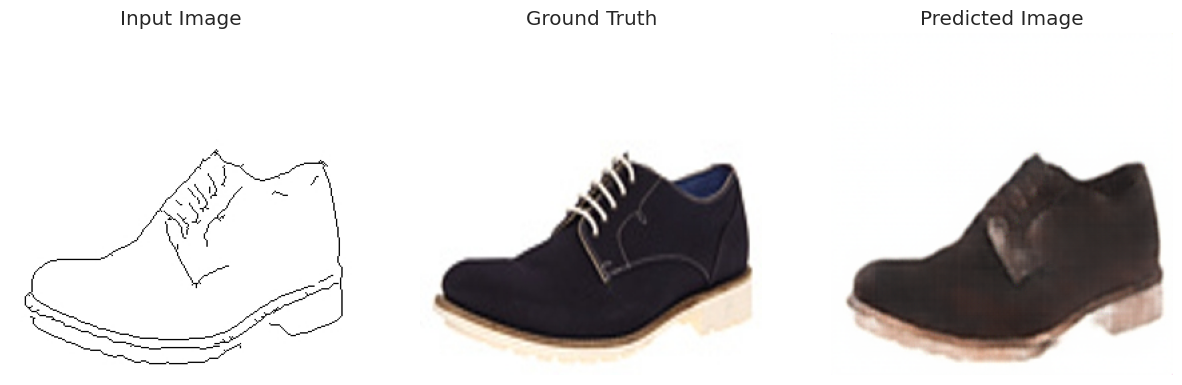

Testing Epoch 6 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17337.78515625
Epoch gen loss: 26418.779296875


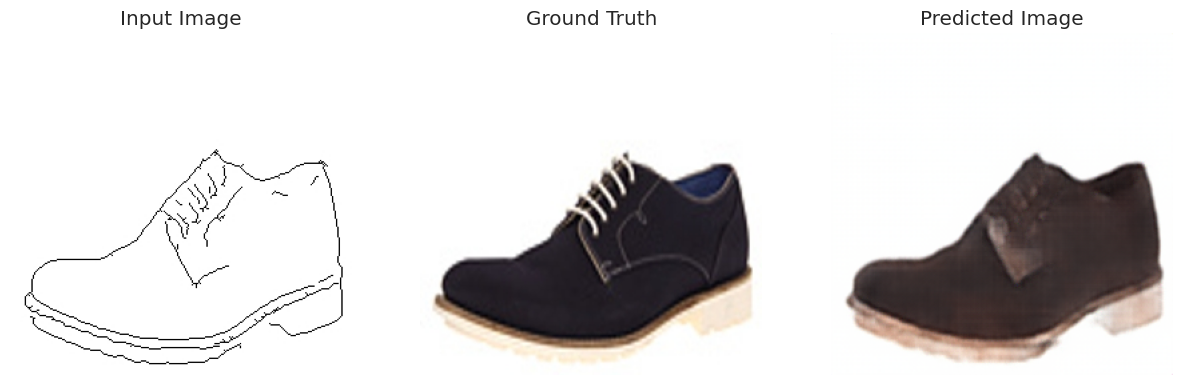

Testing Epoch 7 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17328.84375
Epoch gen loss: 25635.107421875


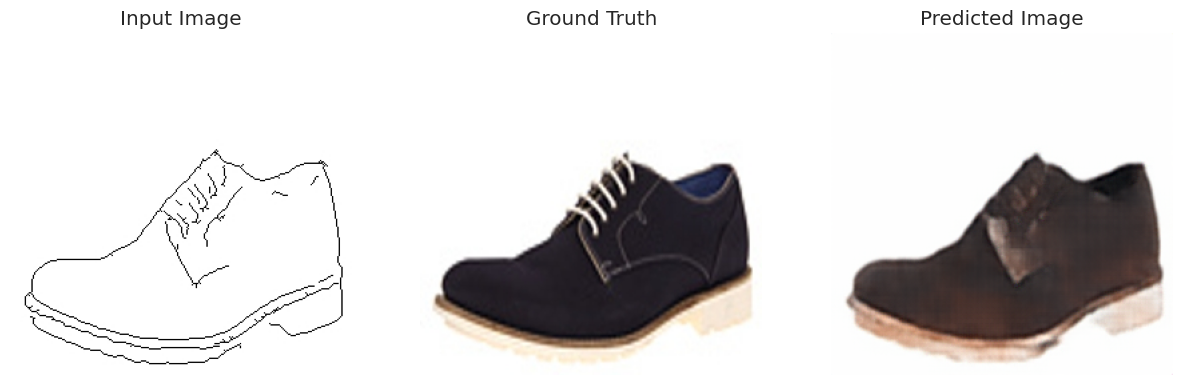

Testing Epoch 8 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17324.669921875
Epoch gen loss: 24943.6875


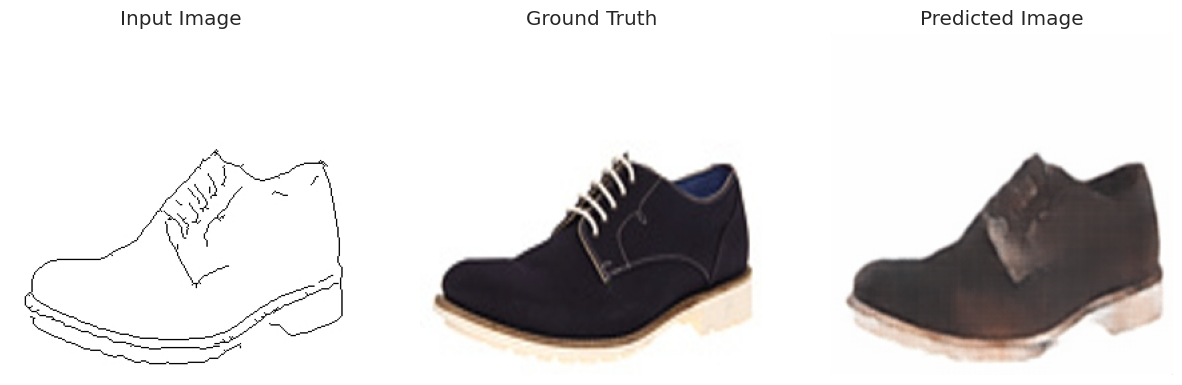

Testing Epoch 9 :   0%|          | 0/24913 [00:00<?, ?it/s]

Epoch disc loss: 17316.916015625
Epoch gen loss: 24332.216796875


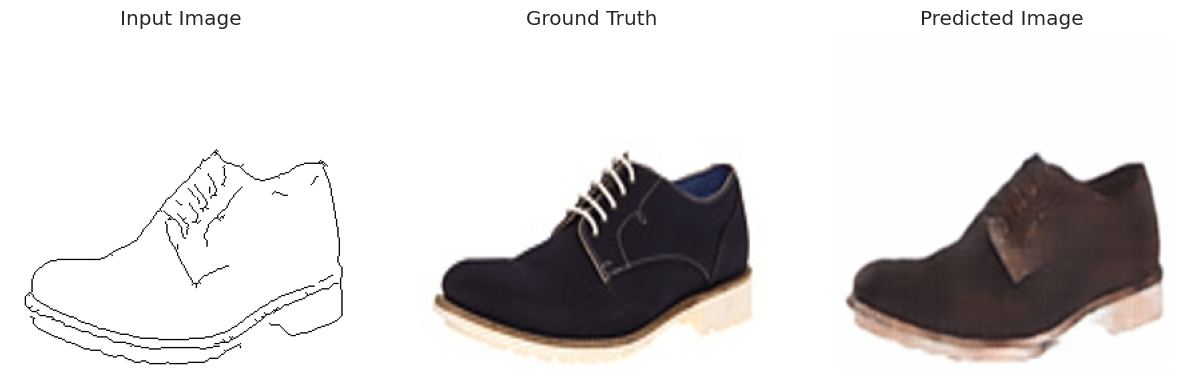

In [29]:
train()

# Проверка генератора на тренировочном датасете

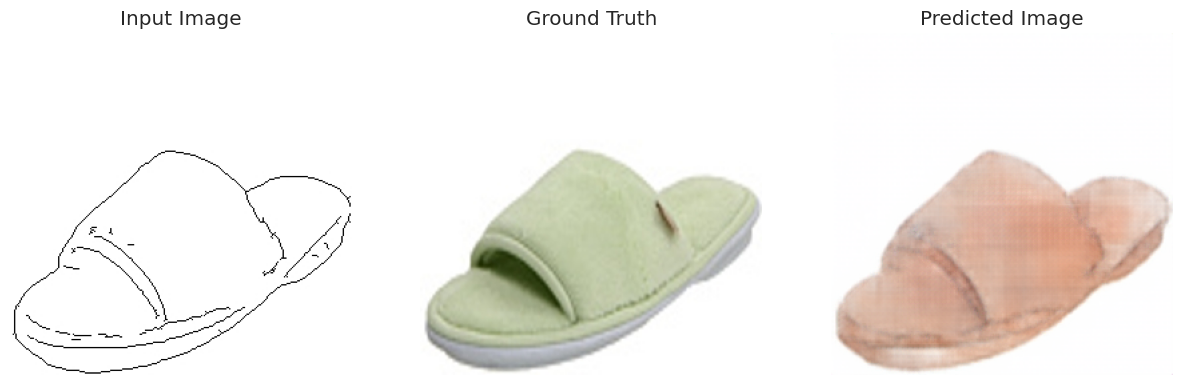

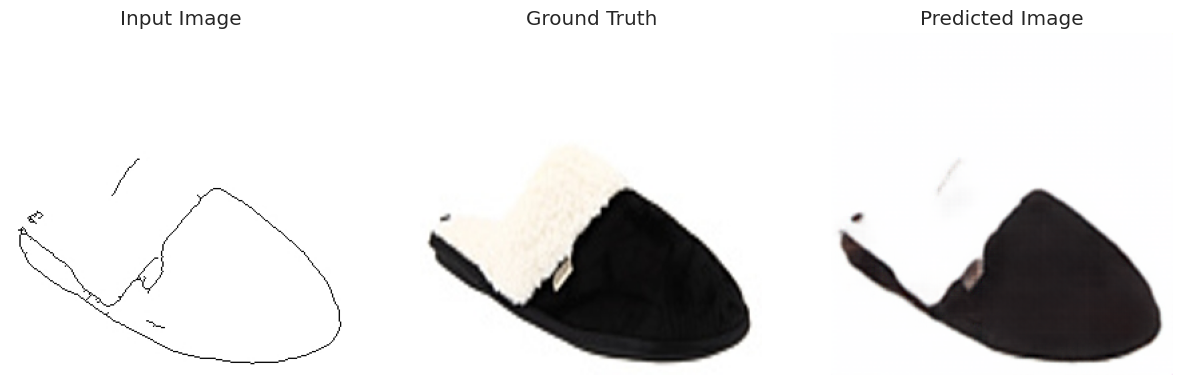

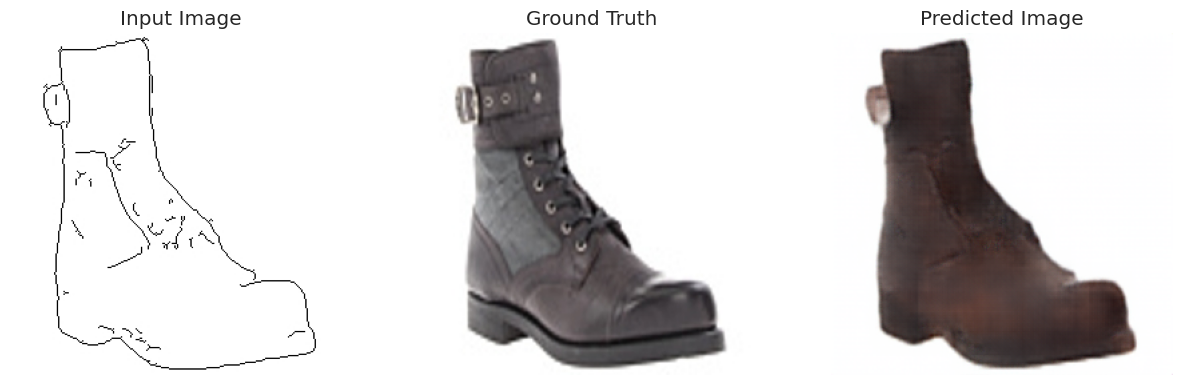

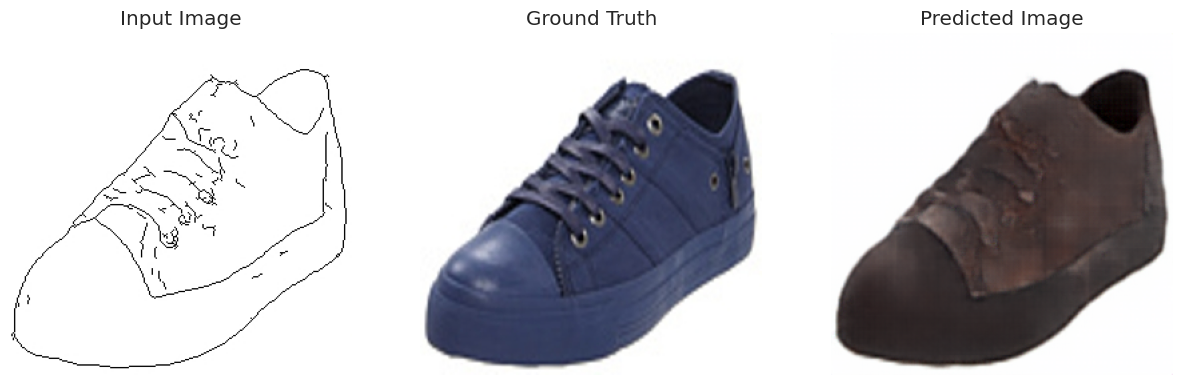

In [30]:
c = 4
i = 0
for batch in train_dataloader:
    if i==c:
        break
    
    batch = batch
    generate_images(generator, batch["A"].to(device), batch["B"].to(device))
    i+=1

# Проверка генератора на тестовом датасете

In [31]:
# Training data loader
val_dataloader = DataLoader(
    ImageDataset("/kaggle/input/edges2shoes-dataset", transforms_=transforms_, mode="val"),
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

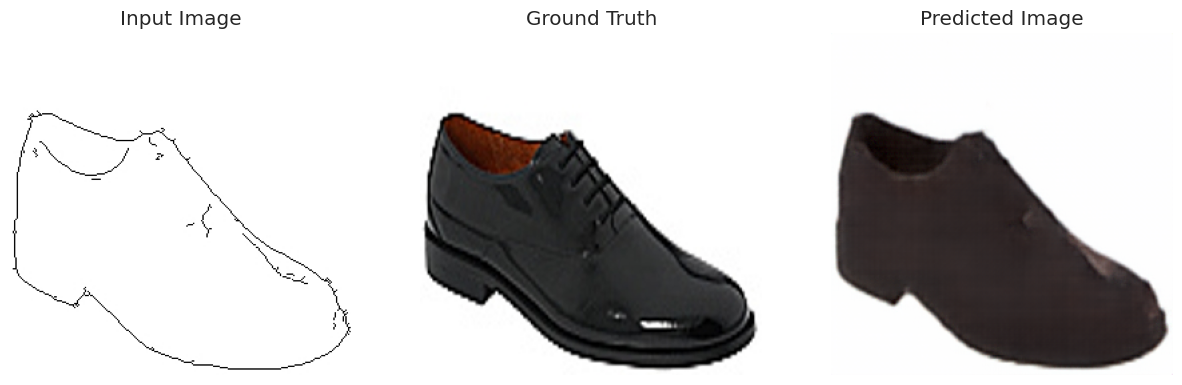

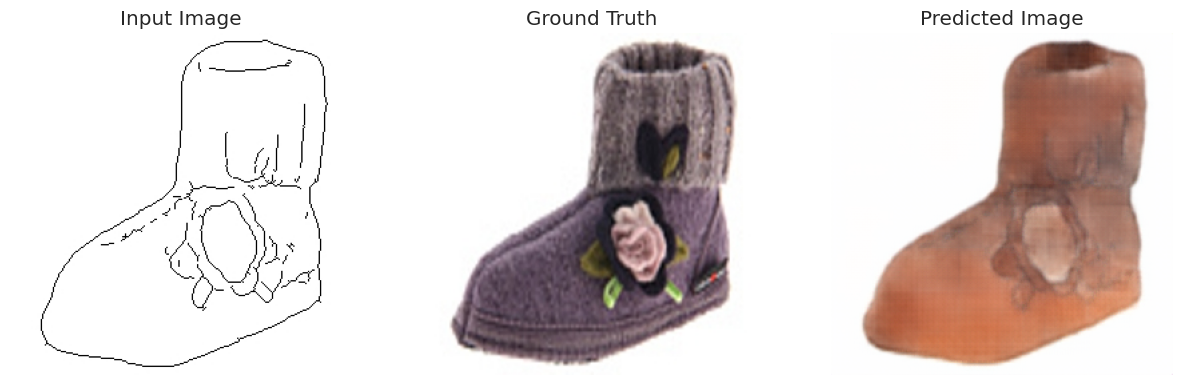

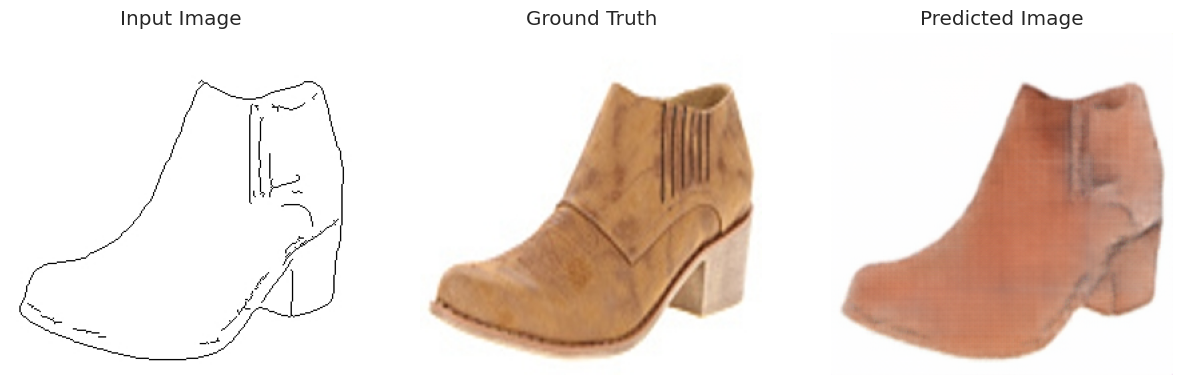

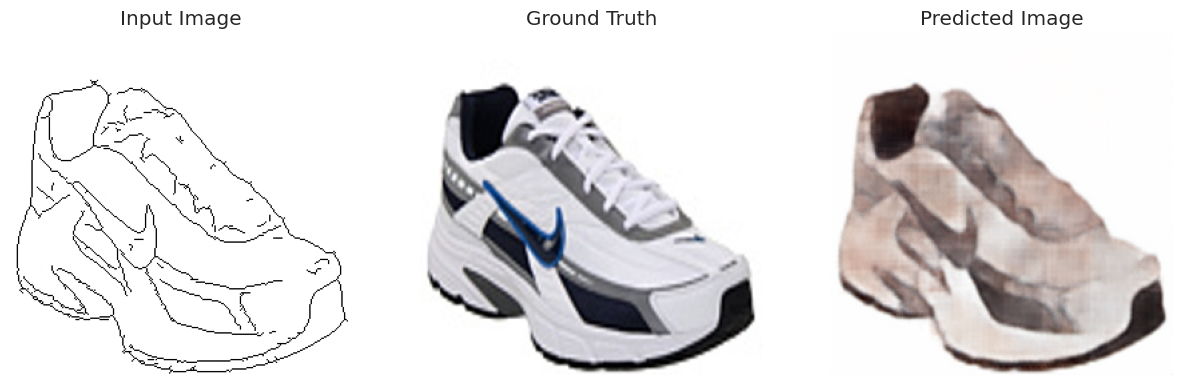

In [32]:
generator.eval()

c = 4
i = 0
for batch in val_dataloader:
    if i==c:
        break
    
    batch = batch
    generate_images(generator, batch["A"].to(device), batch["B"].to(device))
    i+=1

# Проверка генератора на нарисованной человеком (мною) картинке

In [33]:
sample_image = torchvision.io.read_image("/kaggle/input/edges2shoes-custom-ds/sample2.jpg")
sample_image.shape

torch.Size([3, 256, 256])

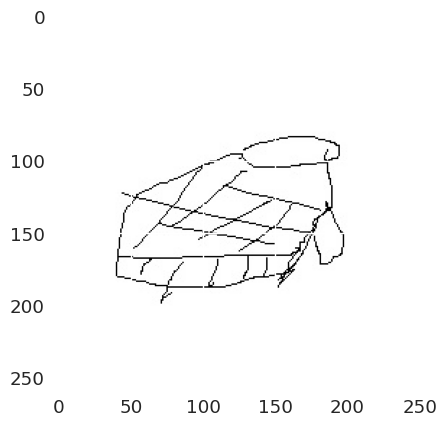

In [34]:
imgplot = plt.imshow(sample_image.permute(1, 2, 0))
plt.show()

In [35]:
sample_image = tt.Compose(transforms_)(tt.functional.to_pil_image(sample_image)).to(device)

In [36]:
# generator.train()
generator.eval()
with torch.no_grad():
    prediction = generator(sample_image.view(1, *sample_image.shape))

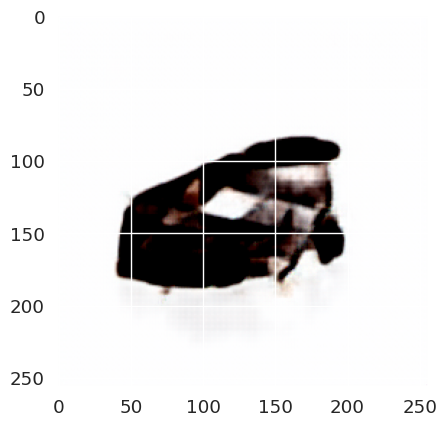

In [37]:
imgplot = plt.imshow(prediction[0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

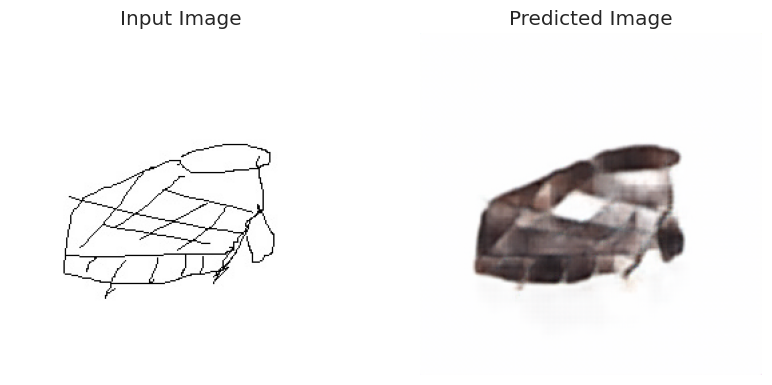

In [38]:
plt.figure(figsize=(15, 15))

display_list = [sample_image.cpu().permute(1, 2, 0), prediction[0].permute(1, 2, 0).cpu().detach().numpy()]
title = ['Input Image', 'Predicted Image']

for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
plt.show()